# Metrics

> 

Start with a brief description of the technical component, and an overview that links to the main symbols in the page (you might want to use doclinks)

In [2]:
#| default_exp metrics

In [3]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [5]:
import warnings
warnings.filterwarnings?

Signature:
warnings.filterwarnings(
    action,
    message='',
    category=<class 'Warning'>,
    module='',
    lineno=0,
    append=False,
)
Docstring:
Insert an entry into the list of warnings filters (at the front).

'action' -- one of "error", "ignore", "always", "default", "module",
            or "once"
'message' -- a regex that the warning message must match
'category' -- a class that the warning must be a subclass of
'module' -- a regex that the module name must match
'lineno' -- an integer line number, 0 matches all warnings
'append' -- if true, append to the list of filters
File:      ~/program_files/managers/conda/envs/yuequ/lib/python3.10/warnings.py
Type:      function

In [6]:
#| export
from namable_classify.utils import default_on_exception, ensure_array
import torch.nn.functional as F
import numpy as np
import torch
from sklearn.metrics import roc_auc_score, top_k_accuracy_score, matthews_corrcoef, f1_score, precision_score, recall_score, log_loss, balanced_accuracy_score, cohen_kappa_score, hinge_loss, accuracy_score

from namable_classify.utils import MuteWarnings
import warnings
except_roc_auc_score = default_on_exception(default_value=-1)(roc_auc_score)

def compute_classification_metrics(
    y_true: np.ndarray,  # 1d array-like, or label indicator array / sparse matrix
    y_pred_logits: np.ndarray = None,  # label indicator array / sparse matrix
    logits_to_prob: bool = False,  # function to convert logits to probabilities
    y_pred: np.ndarray = None,  # predicted labels, if None, will be computed from logits
    labels:list[int|str]|None = None,  # list of labels
    supress_warnings: bool = True,  # whether to suppress warnings
    y_pred_metrics_only: bool = False,  # whether to compute only y_pred related metrics
):
        
    if supress_warnings:
        mute = MuteWarnings()
        mute.mute()
    if y_pred_logits is None:
        assert y_pred_metrics_only == True, "y_pred_logits is None, we can only compute y_pred related metrics! "
        assert y_pred is not None, "y_pred_logits is None, y_pred should be specified! "
        # warnings.warn("y_pred_logits is None, will compute y_pred related metrics only! ")
    y_true = ensure_array(y_true)
    if not y_pred_metrics_only:
        y_pred_logits = ensure_array(y_pred_logits)
        # print(type(y_pred_logits)) # <class 'numpy.ndarray'>
        # y_pred_probs = softmax(y_pred_logits)# label indicator array / sparse matrix
        y_pred_probs = (
            np.array(F.softmax(torch.Tensor(y_pred_logits), dim=1))
            if logits_to_prob
            else y_pred_logits
        )  # label indicator array / sparse matrix
    other_res = {}
    if y_pred is None:
        # 必然有 y_pred_logits
        assert y_pred_logits is not None, "y_pred_logits is None, cannot derive y_pred! "
        y_pred = np.argmax(y_pred_logits, axis=1)
    else:
        # 额外计算一个acc
        if not y_pred_metrics_only:
            warnings.warn("y_pred is specified since it may be different from argmax(y_pred_logits), this may happen to prob SVM. ")
        other_res["acc1_pred"] = accuracy_score(y_true, y_pred)
        
        
    # target_names = labels # dataset['train'].features[label_column_name].names
    # report_dict = classification_report(y_true, y_pred_probs, target_names=target_names, output_dict=True)
    
    if not y_pred_metrics_only:
        top_k_res = {
            f"acc{k}": top_k_accuracy_score(y_true, y_pred_probs, k=k, labels=labels)
            for k in [1, 2, 3, 5, 10, 20]
        }
        prob_res = dict(
            # roc_auc=roc_auc_score(
            roc_auc=except_roc_auc_score(
                y_true, y_pred_probs, average="macro", multi_class="ovr", labels=labels
            ),  # ovr更难一些，会不平衡
            hinge_loss=hinge_loss(y_true, y_pred_probs, labels=labels),
            log_loss=log_loss(
                y_true,
                y_pred_probs,
                labels=labels
                ),
            )
    else: 
        top_k_res = {}
        prob_res = {}

    pred_res = dict(
        matthews_corrcoef=matthews_corrcoef(y_true, y_pred),
        f1=f1_score(y_true, y_pred, average="macro", labels=labels),
        precision=precision_score(y_true, y_pred, average="macro", labels=labels),
        recall=recall_score(y_true, y_pred, average="macro", labels=labels),
        balanced_accuracy=balanced_accuracy_score(y_true, y_pred),
        cohen_kappa=cohen_kappa_score(y_true, y_pred, labels=labels),
    )
    if supress_warnings:
        mute.resume()
    
    # return top_k_res| balance_res| report_dict
    return top_k_res | pred_res | prob_res | other_res

In [7]:
compute_classification_metrics(torch.randint(0, 20, size=(100,)), 
                               torch.softmax(torch.randn(100, 20), dim=1), 
                               logits_to_prob=False, 
                               labels=list(range(20)), 
                               )


{
    'acc1': 0.06,
    'acc2': 0.14,
    'acc3': 0.15,
    'acc5': 0.26,
    'acc10': 0.45,
    'acc20': 1.0,
    'matthews_corrcoef': 0.010008519929895404,
    'f1': 0.059007936507936495,
    'precision': 0.06166666666666666,
    'recall': 0.0625,
    'balanced_accuracy': 0.0625,
    'cohen_kappa': 0.00990099009900991,
    'roc_auc': 0.4607102565379823,
    'hinge_loss': 1.1534419,
    'log_loss': 3.5253246086720487
}

In [10]:
import scikitplot as skplt
import matplotlib.pyplot as plt

#| export
def draw_classification_metrics(
    y_true: np.ndarray,  # 1d array-like, or label indicator array / sparse matrix
    y_pred_logits: np.ndarray = None,  # label indicator array / sparse matrix
    logits_to_prob: bool = False,  # function to convert logits to probabilities
    y_pred: np.ndarray = None,  # predicted labels, if None, will be computed from logits
    labels:list[int|str]|None = None,  # list of labels
    supress_warnings: bool = True,  # whether to suppress warnings
    y_pred_metrics_only: bool = False,  # whether to compute only y_pred related metrics
):
    # 鲁棒性处理
    if supress_warnings:
            mute = MuteWarnings()
            mute.mute()
    if y_pred_logits is None:
        assert y_pred_metrics_only == True, "y_pred_logits is None, we can only compute y_pred related metrics! "
        assert y_pred is not None, "y_pred_logits is None, y_pred should be specified! "
        # warnings.warn("y_pred_logits is None, will compute y_pred related metrics only! ")
    y_true = ensure_array(y_true)
    if not y_pred_metrics_only:
        y_pred_logits = ensure_array(y_pred_logits)
        # print(type(y_pred_logits)) # <class 'numpy.ndarray'>
        # y_pred_probs = softmax(y_pred_logits)# label indicator array / sparse matrix
        y_pred_probs = (
            np.array(F.softmax(torch.Tensor(y_pred_logits), dim=1))
            if logits_to_prob
            else y_pred_logits
        )  # label indicator array / sparse matrix
    other_res = {}
    if y_pred is None:
        # 必然有 y_pred_logits
        assert y_pred_logits is not None, "y_pred_logits is None, cannot derive y_pred! "
        y_pred = np.argmax(y_pred_logits, axis=1)
    else:
        # 额外计算一个acc
        if not y_pred_metrics_only:
            warnings.warn("y_pred is specified since it may be different from argmax(y_pred_logits), this may happen to prob SVM. ")
            
    
    # 核心功能

    if not y_pred_metrics_only:
        skplt.metrics.plot_roc(y_true, y_pred_probs)
        plt.show()
        skplt.metrics.plot_precision_recall(y_true, y_pred_probs)
        plt.show()
    
        if len(labels) == 2:
            skplt.metrics.plot_ks_statistic(y_true, y_pred_probs)
            plt.show()

    skplt.metrics.plot_confusion_matrix(y_true, y_pred)
    plt.show()
    
    if supress_warnings:
        mute.resume()

    return

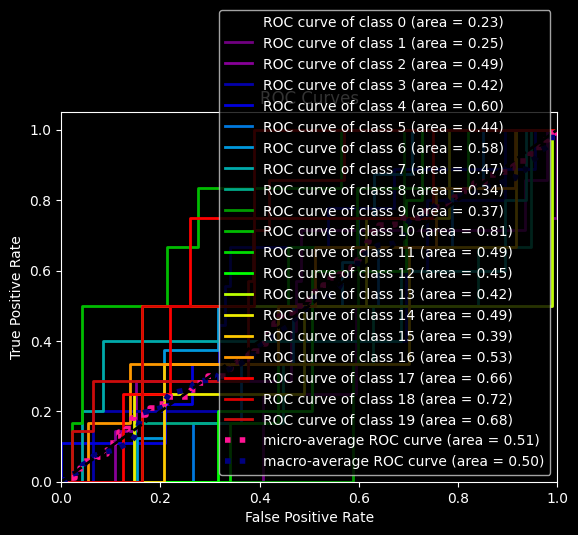

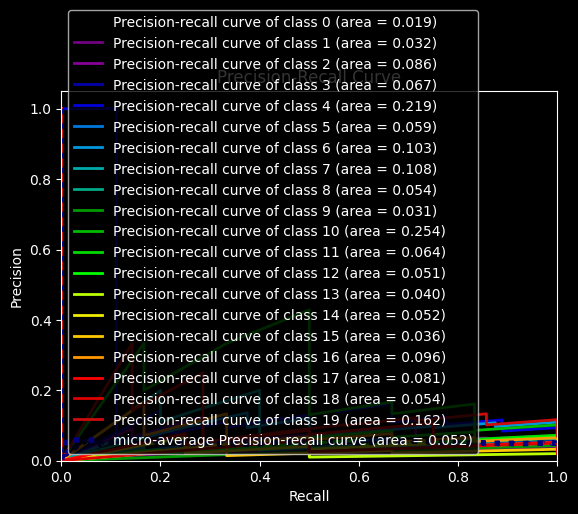

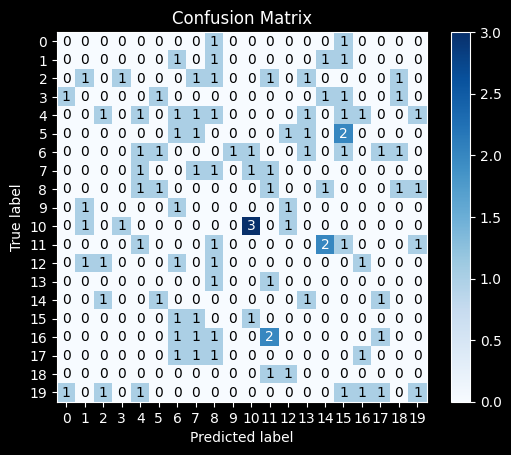

In [11]:
draw_classification_metrics(torch.randint(0, 20, size=(100,)), 
                               torch.softmax(torch.randn(100, 20), dim=1), 
                               logits_to_prob=False, 
                               labels=list(range(20)), 
                               )

In [ ]:
[1,2,3].pop(0)
warnings.warn("This is a warning")

/tmp/ipykernel_1542695/3728250618.py:2: UserWarning: This is a warning
  warnings.warn("This is a warning")


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()